In [213]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import nbconvert

Modifiable Params
==================

Change the parameters in the following cell to change properties of the plot at the bottom

In [214]:
field = ['cases', 'deaths'][0] # switch index to do cases vs deaths
# Note that as of April 29, "deaths" are noisy for states other than, e.g., New York, New Jersey

other_field = [f for f in ['cases', 'deaths'] if f != field][0]

# set to False to sort based on absolute case or death count
# set to True to sort (and plot) based on per-100k case or death count
per_capita = False
per_capita =  True

# Data for low population counties can get noisy.
# This flag allows one to drop counties with population below a threshold
# Only active when per_capita is True
population_drop_thresh = 60000
# population_drop_thresh = 100

# state = ["California", "Arizona", "Nevada", "Oregon", "Washington", "Texas"] # switch to, e.g., 'New York'
# state = ["Florida", "Texas"]
# state = ["New York", "New Jersey"]
# state = "Georgia"
# state= ["Texas"]
# state = ["Nebraska", "New York", "California"]
# state = ["Washington"]
# state = ["Texas", "California"]
# set to None to view the top counties in the entire US
# e.g.
state = None
# set to a list to aggregate all counties from all states in the list
# e.g.
# state = ['Virginia', 'Maryland', 'District of Columbia']
# state = ["California", "Virginia"]
# state = ["Georgia", "New Mexico"] # for a selection of rural counties with outbreaks
# state = ["New Mexico", "Arizona", "Colorado", "Nevada"]

# magic_date = "2020-05-14" # date to highlight on plots
# Uncomment any of the lines below to use that date as the magic date
magic_date = "2020-03-19" # is the start of the California Shelter-In-Place
# magic_date = "2020-03-17" # is the start of the Bay Area Shelter-In-Place
# magic_date = "2020-03-20" # is the start of the New York State SIP
# magic_date = "2020-03-30" # is the DC/Maryland/Virginia SIP
# magic_date = "2020-03-31" # is the Tennessee SIP start
# magic_date = "2020-04-07" # is the infamous Wisconsin election
# magic_date = "2020-04-24" # is the Georgia re-opening date
# magic_date = "2020-05-01" # is the Texas re-opening date
# magic_date = "2020-05-12" # Wisconsin court-ordered re-opening
magic_date = "2020-05-18" # San Mateo County partial re-opening
# magic_date = "2020-05-14" # Some Oregon counties re-opened
# magic_date = "2020-06-06" # maybe florida re-opening date?
# magic_date = 

# It takes a while for policy changes to be reflected in the data,
# so we plot markers at some number of days after the magic date
# The following is a list of delays at which to place markers
offset_magic_date_by = [0,
                        5, # estimated incubation period of COVID-19
                        12, # a few days after estimated incubation period of COVID-19
                       ]
# make this list empty to eliminate all magic date markers
# e.g.
# offset_magic_date_by = []

# Sometimes, in addition to top counties, you also want to compare particular counties.
# This is most useful when doing per 100k on the whole country
extra_counties = []
# extra_counties = ["DeKalb", "Fulton"]
# extra_counties = ["New York City", "Cook", "Los Angeles"]
# extra_counties= ["Dane", "Santa Clara"]
# extra_counties = ["Catoosa"]
# extra_counties = ["Santa Clara", ("California", "Orange"), "San Francisco", "San Mateo", "Alameda", "Contra Costa", "New York City", "Sacramento", "Los Angeles"]
extra_counties = ["Santa Clara", "San Francisco", "San Mateo", "Alameda", "Contra Costa", "Sacramento", "El Dorado", "Los Angeles"]
extra_counties.append(("Nevada", "Clark"))
extra_counties.append("New York City")
# extra_counties = ["Santa Clara", "San Francisco", "San Mateo", "Alameda", "Santa Cruz", "Sacramento", "Los Angeles", "New York City"]
# extra_counties = ["Santa Clara", "San Francisco", "San Mateo", "Alameda", "Contra Costa", "Sacramento", "Solano", "Napa", "Sonoma", "Santa Cruz", "Marin"]
# extra_counties = ["Santa Clara", "Sacramento"]
# extra_counties = ["Imperial", "Kings", "Los Angeles", "Alameda", "San Mateo", "Santa Clara", "Tulare"]
# extra_counties = ["Prince George's", "Los Angeles", "Fairfax", "Cook", "District of Columbia"]
# extra_counties = ["Santa Clara", "Sacramento", "San Mateo", "Fairfax", "Snohomish", "New York City", "Los Angeles", "Cook"]
# extra_counties = ["McKinley", "Apache", "Cook", "Los Angeles"]
# extra_counties = ["Brown", "Milwaukee", "Racine", "Kenosha", "Walworth", "Cook", "Los Angeles"]
# extra_counties = ["Dane", "Green", "Columbia"]
# extra_counties = [("California","Orange"), "San Diego", "Los Angeles", "New York City", "Cook", "San Mateo"]
# extra_counties = ["Dallas", "Walker"]
# extra_counties = ["Summers", "Greenbrier", "Monroe", "Mercer", "Fayette", "Raleigh", "Giles"]
# extra_counties = ["Los Angeles", ("Texas", "Dallas"), ("Texas", "Walker"), "San Francisco", ("California", "Marin"), ("California", "Imperial"), ("New York", "New York City")]
show_this_many_counties = 14 # You probably don't want to exceed 12 here
# show_this_many_counties = len(extra_counties) # uncomment this to only show highlighted counties

In [215]:
# The following are paremeters affecting how the program displays and computes data
smoothing_window = 21 # use any positive integer, but values above 5 work best
magic_date_marker_size = 20


Read the data
=============

Code and helper utils for actually ingesting the data

In [216]:
fname = "covid-19-data/us-counties.csv"
pop_data_fname = "us-census-data/county_data.csv"

In [217]:
county_pops = {}
csv_reader = csv.DictReader(open(pop_data_fname, 'r', newline='', encoding='ISO-8859-1'))
for entry in csv_reader:
    # print(entry['STNAME'] + " - " + entry['CTYNAME'])
    state_entry = county_pops.get(entry['STNAME'], {})
    county_name = entry["CTYNAME"].replace(" County", "")
    state_entry[county_name] = float(entry["POPESTIMATE2019"])
    county_pops[entry['STNAME']] = state_entry
county_pops["New York"]["New York City"] = 8.399e6
print("LA -> " + str(county_pops["California"]["Los Angeles"]))
print("Catoosa -> " + str(county_pops["Georgia"]["Catoosa"]))
print("Grimes -> " + str(county_pops["Texas"]["Grimes"]))

LA -> 10039107.0
Catoosa -> 67580.0
Grimes -> 28880.0


In [218]:
csv_reader = csv.DictReader(open(fname))
data = []
print(state)
for entry in csv_reader:
    if entry['county'].lower() == "unknown":
        continue
    if type(state) == type([]) and not entry['state'] in state:
        continue
    if type(state) == type("") and not entry['state'] == state:
        continue
    raw_pop = county_pops.get(entry['state'], {}).get(entry['county'], 0.0)
    if per_capita:
        if raw_pop <= 0.0 or raw_pop < population_drop_thresh:
            continue
        entry['population'] = raw_pop
    entry['county'] = entry['state'] + " - " + entry['county']
    data.append(entry)


None


In [219]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_from_daynum(daynum):
    return datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=daynum)
    
# then we convert our magic date to a number
magic_date_nums = [entry_to_days({'date': magic_date}) + i for i in offset_magic_date_by]
magic_date_nums

[138, 143, 150]

In [220]:
date_from_daynum(120).strftime("%Y-%m-%d")

'2020-04-30'

In [221]:
# Here we just peek at a cell in the data
data[0]

OrderedDict([('date', '2020-01-21'),
             ('county', 'Washington - Snohomish'),
             ('state', 'Washington'),
             ('fips', '53061'),
             ('cases', '1'),
             ('deaths', '0'),
             ('population', 822083.0)])

In [222]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    val = float(d[field])
    other_val = float(d[other_field])
    if per_capita:
        val = 100000 * val / d['population'] # per 100k
        other_val = 100000 * other_val / d['population']
    l.append([entry_to_days(d), val, other_val])
    counties[d['county']] = l

In [223]:
len(counties)

848

Code to extract a trajectory for an individual county and plot it
========================

The following functions extract
1. the time series of cumulative caseload for a given county
2. the time series of the average daily change in cumulative caseload over the past "window" days
3. a time series of integers corresponding to number of days after 2020-01-01

and then provide utilities for plotting the average daily change on the y axis
against the cumulative caseload on the x axis on a plot in which each axis
is logarithmically scaled.

Overview of plot meaning
-------------------------------------

For many (but certainly not all) common dynamical systems, a "phase plot" or "phase portrait"
of a time series can be made by plotting a key value of the system on the x axis, plotting
the rate of change of that value on the y axis, and not explicitly plotting time.
(The technical definition of a phase portrait is very different from this,
but the two match up for many of the sorts of systems seen in basic physics).

Such plots highlight certain aspects of a given time series while de-emphasizing others.

In particular, for rapidly growing functions, a phase portrait in which each axis is on
a log scale quickly and easily reveals which family of functions the growth of the quantity
most resembles, rather than what the instantaneous growth rate is.

Purely exponential growth corresponds to lines in this plot with a slope of `1`.
Changing the base of the exponent merely shifts these lines up or down in the plot without
changing their slope.
Quadratic growth corresponds to lines in this plot with a slope of `1/2`.
Polynomial growth with a power of `p` produces lines with a slope of `(p-1)/p`

In [224]:
def trajectory(county, window=5):
    """This just extracts the time series of cumulative caseload, the time series
    of the smoothe (but laggy) rate of change of cumulative caseload, and, to aid
    in marker placement, the time series of date indices (# of days since a reference date)"""
    raw = sorted(counties[county], key = lambda e: e[0])
    date_nums = [raw[i][0] for i in range(window, len(raw))]
    rates = [(float(raw[i][1]) - float(raw[i-window][1])) / (raw[i][0] - raw[i-window][0])
             for i in range(window, len(raw))]
    cums = [float(r[1]) for r in raw[window:]]
    other_cums = [float(r[2]) for r in raw[window:]]
    indices = [i for i in range(len(cums)) if cums[i] > 1 and rates[i] > 1]
    if per_capita:
        thresh = 1e4/population_drop_thresh
        indices = [i for i in range(len(cums)) if cums[i] > thresh and rates[i]  > thresh]
    return [[cums[i] for i in indices], [rates[i] for i in indices], [date_nums[i] for i in indices],
           [other_cums[i] for i in indices]]

In [225]:
def plot_traj(county, color, window=5, suffix="", absolute=False):
    """This plots the time series extracted by the
    'trajectory' function on a log/log plot.
    
    It also marks where the trajectory is at any dates
    corresponding to n days after 'magic_date' for each
    n in `offset_magic_date_by`."""
    data = trajectory(county, window=window)
    if not absolute:
        plt.yscale('log')
        plt.xscale('log')
    plt.ylabel('average new ' + field + suffix + ' per day')
    plt.xlabel('cumulative ' + field + suffix)
    plt.plot(data[0], data[1], color, label=county)
    magic_date_color = color[0] + "o"
    magic_date_index = [i for i in range(len(data[0])) if data[2][i] in magic_date_nums]
    if len(magic_date_index) > 0:
        plt.plot([data[0][i] for i in magic_date_index], [data[1][i] for i in magic_date_index], magic_date_color,
                markersize = magic_date_marker_size)
        # uncomment the next two lines to get a feel for the growth rate via printouts, and double-check estimates
        # of growth rates
        # for i in magic_date_index:
        #    print(county + " on date " + str(i) + " has state " + str((data[0][i], data[1][i])))

In [226]:
def plot_time_series(county, color, window=5, suffix = "", absolute=False, rate=False):
    """This plots the time series extracted by the
    'trajectory' function on a log/log plot.
    
    It also marks where the trajectory is at any dates
    corresponding to n days after 'magic_date' for each
    n in `offset_magic_date_by`."""
    data = trajectory(county, window=window)
    if not absolute:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xscale('linear')
    plt.xlabel('days since 2020-01-01')
    if rate:
        plt.ylabel('smoothed daily rate of change of ' + field + suffix)
    else:
        plt.ylabel('cumulative ' + field + suffix)
    data_index = 0
    if rate:
        data_index = 1
    plt.plot(data[2], data[data_index], color, label=county)
    magic_date_color = color[0] + "o"
    magic_date_index = [i for i in range(len(data[data_index])) if data[2][i] in magic_date_nums]
    if len(magic_date_index) > 0:
        plt.plot([data[2][i] for i in magic_date_index], [data[data_index][i] for i in magic_date_index],
                 magic_date_color,
                markersize = magic_date_marker_size)


Helper class for grabbing different colors and line styles for plotting

In [227]:
class ColorPicker:
    def __init__(self):
        self.colors = [c + "-" for c in "kbrgcm"] + [c + "--" for c in "kbrgcm"]
        self.i = 0
    def get(self):
        c = self.colors[self.i]
        self.i += 1
        self.i = self.i % len(self.colors)
        return c




THE ACTUAL PLOTS
================

The part you've been waiting for, amirite?

Caveat
------

Right now the naive smoothing method being used causes lag in the "average new cumulative cases per day"

This can cause shifting in these phase plots that will make exponential growth at one rate
look like exponential growth at a slower rate.

I believe that it should still be okay to use this chart to qualitatively determine
1. which counties are experiencing exponential growth
2. which exponential growth trajectories are slower or faster than which other ones

This code snippet also computes most recent approximate doubling times for each county.
These should only be valid for counties for which the cumulative case load is still growing exponentially.

For instance, as of early May, it looked as if this wasn't the case for Dougherty or Sumter counties in Georgia.

This may change, though, for those particular counties.  Georgia is showing strange and fascinating dynamics.

In [228]:
def top_n_from(total_list, def_include_these, n):
    """You want to show n counties, but you want to make sure the ones in
    def_include_these are included.  This is how you do it."""
    def_include_these = [c for c in def_include_these if c in total_list]
    leftover = [c for c in total_list if c not in def_include_these]
    n_to_include = max(0, n - len(def_include_these))
    results = leftover[:n_to_include] + def_include_these
    return sorted(results, key=lambda c: -1.0 * trajectory(c)[0][-1])

In [229]:
def find_extra_counties():
    return [c for c in counties.keys() if c.split(" - ")[-1] in extra_counties
            or tuple(c.split(" - ")) in extra_counties]

California - Imperial cumulative cases per 100k : 6571.199955853544
California - Imperial smoothed daily new cases per 100k : 14.01649973788044
California - Imperial cumulative deaths per 100k : 176.03399277101786
About 1 in 568.07 residents of  California - Imperial have died so far from COVID-19
California - Imperial cumulative cases per 100k currently doubles about once every 205.32 days
California - Imperial daily new cases per 100k currently doubles about once every 45.15 days
California - Imperial max (smoothed) daily new cases per 100k was 136.964379328422
Last data entry for California - Imperial was 2020-09-30
################################################################################
Florida - Miami-Dade cumulative cases per 100k : 6271.724808056122
Florida - Miami-Dade smoothed daily new cases per 100k : 11.961986646742298
Florida - Miami-Dade cumulative deaths per 100k : 120.72404985019912
About 1 in 828.34 residents of  Florida - Miami-Dade have died so far from COVID

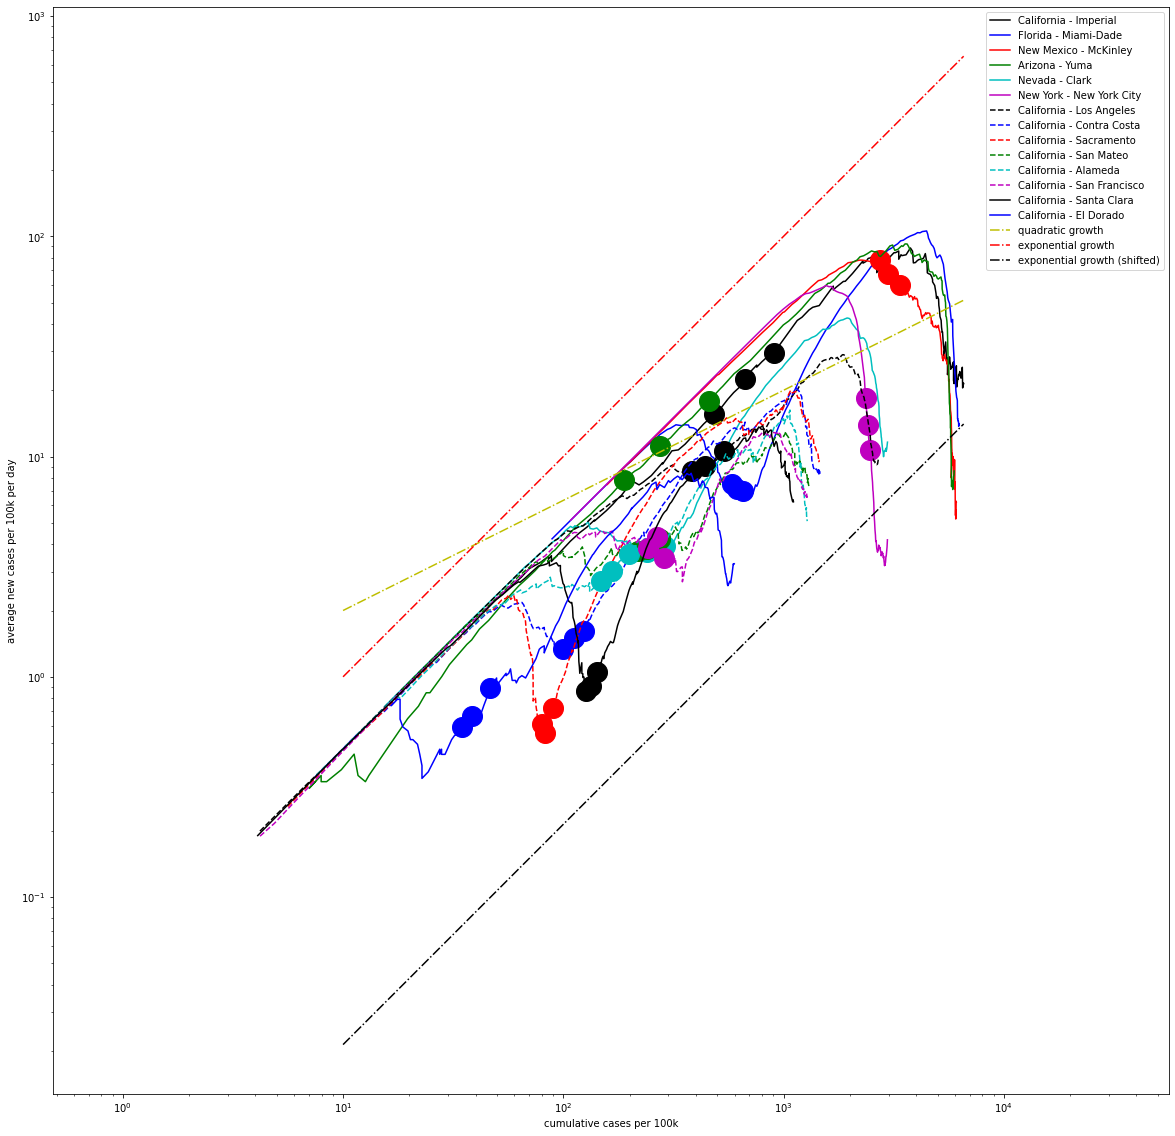

In [230]:
col_pick = ColorPicker()
plt.rcParams['figure.figsize'] = [20,20]
plt.axes().set_aspect('equal', 'datalim')
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
suffix = ""
if per_capita:
    suffix = " per 100k"
extra = find_extra_counties()
for county in top_n_from(valid_counties, extra, show_this_many_counties):
    t = trajectory(county)
    plot_traj(county, col_pick.get(), window=smoothing_window, suffix=suffix)
    print(county + " cumulative " + field + suffix + " : "+ str(trajectory(county)[0][-1]))
    print(county + " smoothed daily new " + field + suffix + " : "+ str(trajectory(county)[1][-1]))
    print(county + " cumulative " + other_field + suffix + " : " + str(trajectory(county)[3][-1]))
    try:
        if per_capita and other_field == "deaths":
            print("About 1 in {:.2f} residents of ".format(100000/trajectory(county)[3][-1]) +
                 " " + county + " have died so far from COVID-19")
        doublings_per_day = np.log(t[0][-1]/t[0][-smoothing_window-1])/((t[2][-1] - t[2][-smoothing_window-1]) * np.log(2))
        days_to_double = 1.0/doublings_per_day
        print(county + " cumulative " + field + suffix +
              " currently doubles about once every {:.2f} days".format(days_to_double))
        if t[1][-1] > t[1][-smoothing_window-1]:
            doublings_per_day = np.log(t[1][-1]/t[1][-smoothing_window-1])/((t[2][-1] - t[2][-smoothing_window-1]) * np.log(2))
            days_to_double = 1.0/doublings_per_day
            print(county + " daily new " + field + suffix +
                  " currently doubles about once every {:.2f} days".format(days_to_double))
    except:
        print("Could not compute doublings per day for " + county)
    print(county + " max (smoothed) daily new " + field + suffix + " was " +
          str(max(t[1])))
    print("Last data entry for " + county + " was " + date_from_daynum(t[2][-1]).strftime("%Y-%m-%d"))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
    print("".join(["#" for i in range(80)]))

plt.plot([10.0, maxpt], [2.0, 2.0 * np.sqrt(0.1 * maxpt)], 'y-.', label="quadratic growth")
plt.plot([10.0, maxpt], [1.0, 0.1 * maxpt], 'r-.', label="exponential growth")
plt.plot([10.0, maxpt], [10.0 * maxrate / maxpt, maxrate], 'k-.', label="exponential growth (shifted)")
plt.legend()
print("shifted exponential reference line multiplies doubling time by " + str(0.1 * maxpt/maxrate))
print("curves lining up with upper exponential have doubling times of approximately " +
      "{:.2f}".format(np.log(2)/0.1) + " days")
print("curves lining up with lower exponential have doubling times of approximately " + 
      "{:.2f}".format(np.log(2)*maxpt/maxrate) + " days")
print("Because of how smoothing causes lag in cumulative case derivative,")
print("exponential rates seen on chart might not match computations.")
print("Charts should be used for qualitative analysis only at this point")

Time series plots
----------------------

And, for comparison, cumulative confirmed cases, by county, as a time series, on a semi-log (y log-scale, x linear) plot

California - Imperial cumulative cases per 100k : 6571.199955853544
Florida - Miami-Dade cumulative cases per 100k : 6271.724808056122
New Mexico - McKinley cumulative cases per 100k : 6085.44565415388
Arizona - Yuma cumulative cases per 100k : 5954.5248307895245
Nevada - Clark cumulative cases per 100k : 2963.583864755825
New York - New York City cumulative cases per 100k : 2961.5192284795808
California - Los Angeles cumulative cases per 100k : 2692.4605943536612
California - Contra Costa cumulative cases per 100k : 1464.7264127553258
California - Sacramento cumulative cases per 100k : 1459.545970575842
California - San Mateo cumulative cases per 100k : 1303.202695633684
California - Alameda cumulative cases per 100k : 1280.6574887409959
California - San Francisco cumulative cases per 100k : 1279.338981724215
California - Santa Clara cumulative cases per 100k : 1108.9544218124627
California - El Dorado cumulative cases per 100k : 596.8585844443407


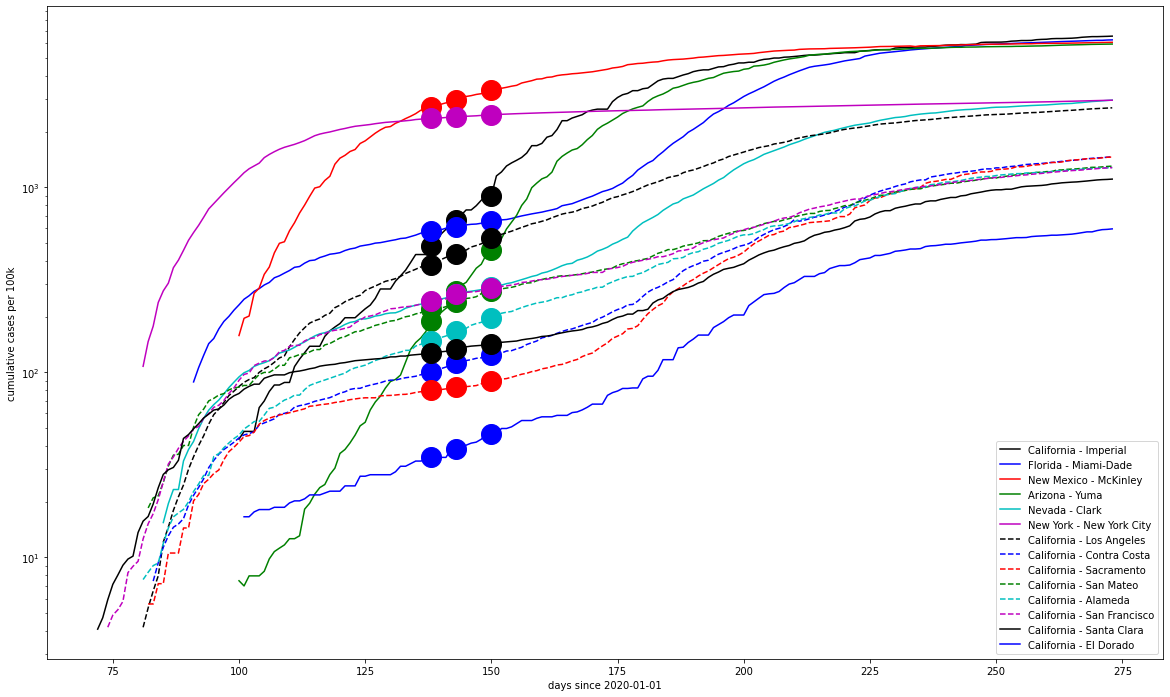

In [231]:
col_pick = ColorPicker()
phi = 0.5 * (1 + np.sqrt(5.0))
plt.rcParams['figure.figsize'] = [20,int(20/phi)]
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
extra = find_extra_counties()
suffix = ""
if per_capita:
    suffix = " per 100k"
for county in top_n_from(valid_counties, extra, show_this_many_counties):
    t = trajectory(county)
    plot_time_series(county, col_pick.get(), window=smoothing_window, suffix=suffix)
    print(county + " cumulative " + field + suffix + " : "+ str(trajectory(county)[0][-1]))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
plt.legend()

Linear scale plots
==================

Out of curiosity, and motivated by a couple of things I read online suggesting that major
newspapers not print COVID-19 caseload time series on a semi-log scale, I decided 
to re-plot each of the above graphs in a linear scale.

I found that the phase space plot is far less interesting and less readable on that scale.

But I think the time series plots show things in the linear scale that aren't readily visible on the semilog time series plots

California - Imperial cumulative cases per 100k : 6571.199955853544
Florida - Miami-Dade cumulative cases per 100k : 6271.724808056122
New Mexico - McKinley cumulative cases per 100k : 6085.44565415388
Arizona - Yuma cumulative cases per 100k : 5954.5248307895245
Nevada - Clark cumulative cases per 100k : 2963.583864755825
New York - New York City cumulative cases per 100k : 2961.5192284795808
California - Los Angeles cumulative cases per 100k : 2692.4605943536612
California - Contra Costa cumulative cases per 100k : 1464.7264127553258
California - Sacramento cumulative cases per 100k : 1459.545970575842
California - San Mateo cumulative cases per 100k : 1303.202695633684
California - Alameda cumulative cases per 100k : 1280.6574887409959
California - San Francisco cumulative cases per 100k : 1279.338981724215
California - Santa Clara cumulative cases per 100k : 1108.9544218124627
California - El Dorado cumulative cases per 100k : 596.8585844443407


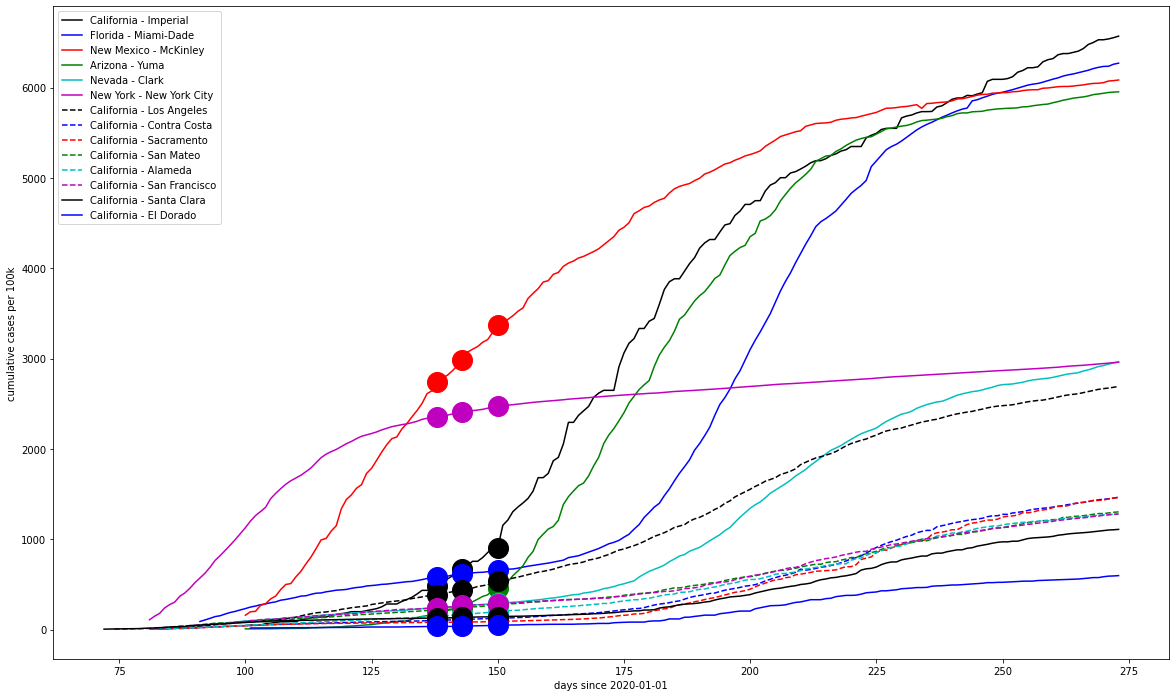

In [232]:
col_pick = ColorPicker()
phi = 0.5 * (1 + np.sqrt(5.0))
plt.rcParams['figure.figsize'] = [20,int(20/phi)]
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
extra = find_extra_counties()
suffix = ""
if per_capita:
    suffix = " per 100k"
for county in top_n_from(valid_counties, extra, show_this_many_counties):
    t = trajectory(county)
    plot_time_series(county, col_pick.get(), window=smoothing_window, suffix=suffix, absolute=True)
    print(county + " cumulative " + field + suffix + " : "+ str(trajectory(county)[0][-1]))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
plt.legend()

California - Imperial smoothed daily change in cases per 100k : 14.01649973788044
Florida - Miami-Dade smoothed daily change in cases per 100k : 11.961986646742298
New Mexico - McKinley smoothed daily change in cases per 100k : 7.56652234225894
Arizona - Yuma smoothed daily change in cases per 100k : 6.174369816686704
Nevada - Clark smoothed daily change in cases per 100k : 14.055582638311353
New York - New York City smoothed daily change in cases per 100k : 5.162519347541365
California - Los Angeles smoothed daily change in cases per 100k : 9.012753823622006
California - Contra Costa smoothed daily change in cases per 100k : 7.403387526592359
California - Sacramento smoothed daily change in cases per 100k : 6.069360809969749
California - San Mateo smoothed daily change in cases per 100k : 5.348479531629755
California - Alameda smoothed daily change in cases per 100k : 4.248116319408064
California - San Francisco smoothed daily change in cases per 100k : 5.376899071974458
California - 

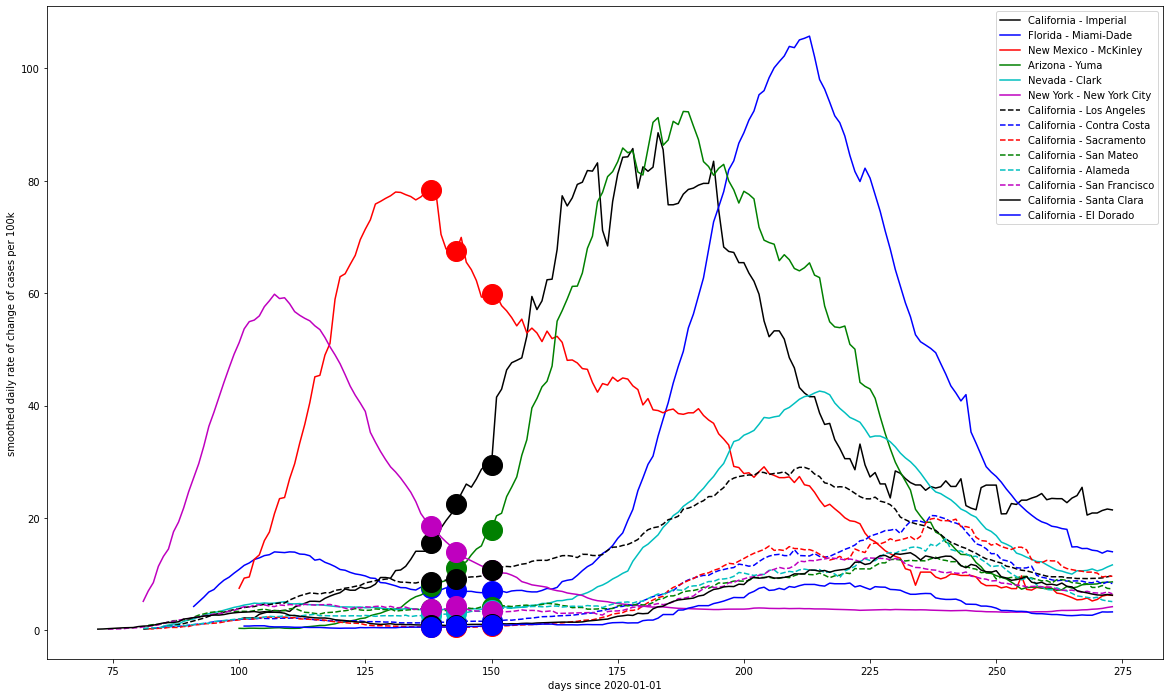

In [233]:
col_pick = ColorPicker()
phi = 0.5 * (1 + np.sqrt(5.0))
plt.rcParams['figure.figsize'] = [20,int(20/phi)]
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
extra = find_extra_counties()
suffix = ""
if per_capita:
    suffix = " per 100k"
for county in top_n_from(valid_counties, extra, show_this_many_counties):
    t = trajectory(county)
    plot_time_series(county, col_pick.get(), window=smoothing_window, suffix=suffix, absolute=True, rate=True)
    print(county + " smoothed daily change in " + field + suffix + " : "+ str(trajectory(county)[1][-1]))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
plt.legend()